In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import pandas as pd

import keras
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('default')

Using TensorFlow backend.


In [27]:
global model
global dataset

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


def myModel(nodes=64,hidden_layers=1, verbose=2, save_path=None):
    model = models.Sequential()
    model.add(layers.Dense(nodes, activation='relu', input_shape=(10000,)))
    for layer in range(hidden_layers):
        model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Set callback functions to early stop training and save the best model so far
    callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
    val_hist = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=verbose)
    
    test_hist = model.evaluate(x_test, y_test)
    model.save(save_path + '/{}/trained_model_{}_nodes_{}_layers'\
               .format(dataset, nodes, hidden_layers))
    return val_hist, test_hist
    
(train_data, train_labels), (test_data, test_labels) = \
    keras.datasets.reuters.load_data(num_words=10000)

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [28]:
x_train.shape

(8982, 10000)

In [29]:
y_train.shape

(8982, 46)

In [30]:
x_test.shape

(2246, 10000)

In [31]:
y_test.shape

(2246, 46)

In [32]:
partial_x_train.shape

(7982, 10000)

In [33]:
y_val.shape

(1000, 46)

In [34]:
node_list =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
layer_list = [1, 2, 3, 4,  5,  6,  7,   8,   9,  10]

#node_list =  [2,4]
#layer_list = [1,4]

dataset = 'reuters'
save_path = 'D:/data/vca/outputs/saved_models'

val_acc = np.zeros(shape=(len(node_list),len(layer_list)))
test_acc = np.zeros(shape=(len(node_list),len(layer_list)))
for i,node in enumerate(node_list):
    for ii,layer in enumerate(layer_list):
        print(node, layer)
        val_hist, test_hist = myModel(nodes=node,
                                      hidden_layers=layer,
                                      verbose=1,
                                      save_path=save_path)
        print(test_hist)
        val_acc[i,ii] = np.max(val_hist.history['val_acc'])
        test_acc[i,ii] = test_hist[1]

df_val = pd.DataFrame(test_acc)
df_val.columns = layer_list
df_val.index = node_list
model_desc = '_layers_' + str(df_val.columns.values) + '_nodes_' + str(df_val.index.values)
df_val.to_csv(save_path + '/{}/val_acc_{}'.format(dataset, model_desc))

df_test = pd.DataFrame(test_acc)
df_test.columns = layer_list
df_test.index = node_list
model_desc = '_layers_' + str(df_test.columns.values) + '_nodes_' + str(df_test.index.values)
df_test.to_csv(save_path + '/{}/test_acc_{}'.format(dataset, model_desc))

1 1
Train on 7982 samples, validate on 1000 samples
Epoch 1/30
7982/7982 [==============================] - 6s 729us/step - loss: 3.8005 - acc: 0.1305 - val_loss: 3.7775 - val_acc: 0.2220
Epoch 2/30
7982/7982 [==============================] - 1s 119us/step - loss: 3.7589 - acc: 0.2957 - val_loss: 3.7382 - val_acc: 0.2220
Epoch 3/30
7982/7982 [==============================] - 1s 101us/step - loss: 3.7200 - acc: 0.3079 - val_loss: 3.6999 - val_acc: 0.3540
Epoch 4/30
7982/7982 [==============================] - 1s 107us/step - loss: 3.6817 - acc: 0.3514 - val_loss: 3.6620 - val_acc: 0.3540
Epoch 5/30
7982/7982 [==============================] - 1s 107us/step - loss: 3.6442 - acc: 0.3458 - val_loss: 3.6248 - val_acc: 0.3540
Epoch 6/30
7982/7982 [==============================] - 1s 113us/step - loss: 3.6071 - acc: 0.3459 - val_loss: 3.5878 - val_acc: 0.3540
Epoch 7/30
7982/7982 [==============================] - 1s 112us/step - loss: 3.5704 - acc: 0.3514 - val_loss: 3.5517 - val_acc: 0.3

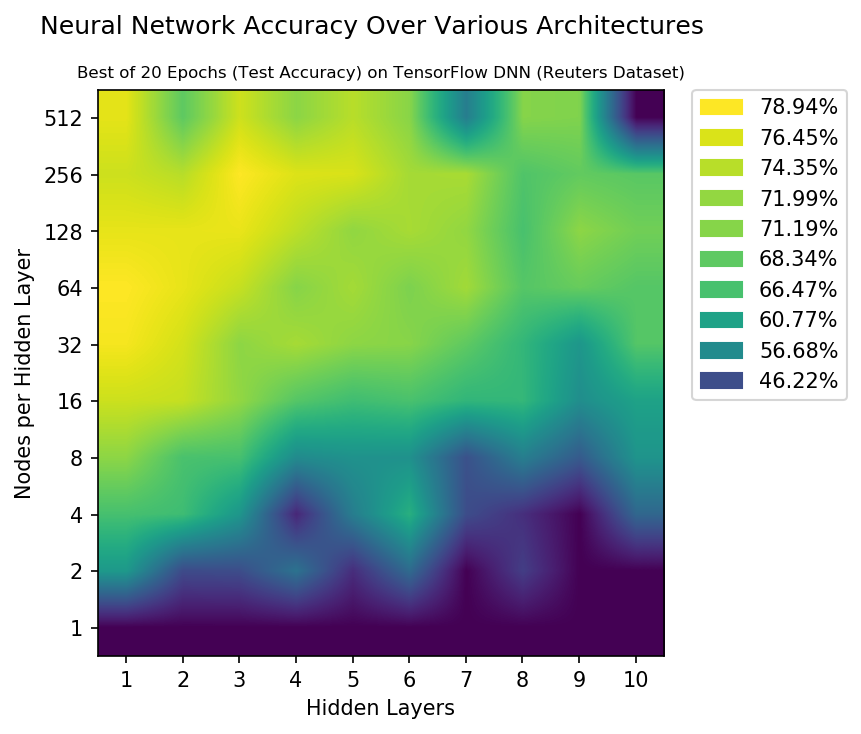

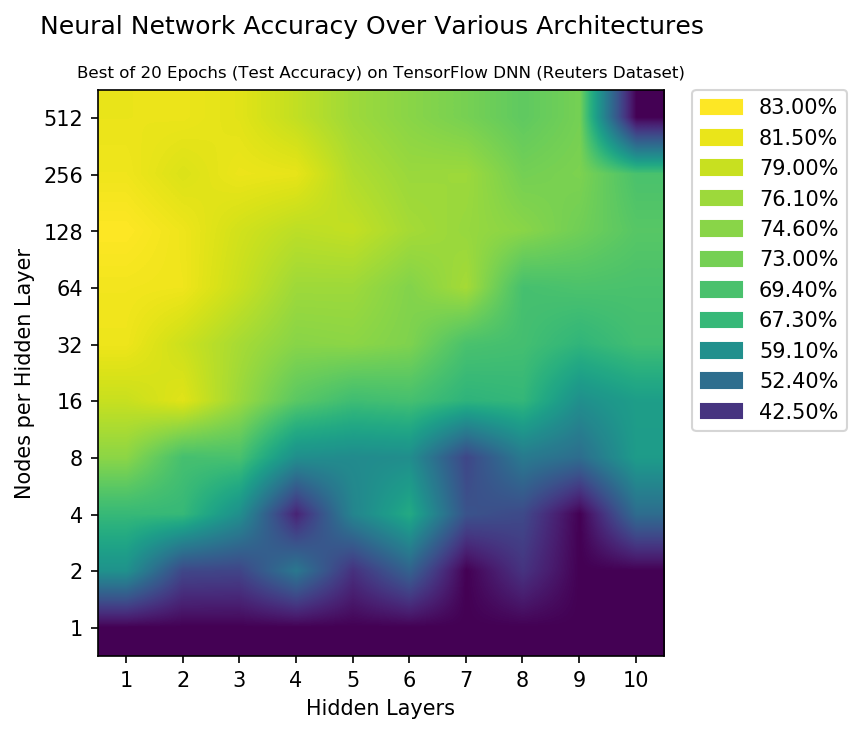

In [40]:
def plot_results(df):
    matrix = np.array(df)
    plt.figure(figsize=(5,5), dpi=150)
    plt.suptitle('Neural Network Accuracy Over Various Architectures', fontsize=12)
    plt.title('Best of 20 Epochs (Test Accuracy) on TensorFlow DNN (Reuters Dataset)', fontsize=8)
    im = plt.imshow(np.flip(matrix,0), interpolation='bilinear')
    plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,4,8,16,32,64,128,256,512][::-1])
    plt.ylabel("Nodes per Hidden Layer")
    plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,3,4,5,6,7,8,9,10])
    plt.xlabel('Hidden Layers')

    values = np.unique(matrix)
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=colors[i], label="{l:.2%}".format(l=values[i]) ) for i in range(len(values))][::-1]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches[::8], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.show()
    
plot_results(test_acc)
plot_results(val_acc)